In [1]:
!wget -O fma_small.zip https://os.unil.cloud.switch.ch/fma/fma_small.zip
!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

--2023-05-01 05:37:37--  https://os.unil.cloud.switch.ch/fma/fma_small.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7679594875 (7.2G) [application/zip]
Saving to: ‘fma_small.zip’

fma_small.zip       100%[===================>]   7.15G  24.9MB/s    in 4m 59s  

2023-05-01 05:42:37 (24.5 MB/s) - ‘fma_small.zip’ saved [7679594875/7679594875]

--2023-05-01 05:42:38--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip’

fma_metadata.zip    100%[===================>] 341.81

In [2]:
import zipfile
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

with zipfile.ZipFile('fma_small.zip', 'r') as zip_ref:
    # Get the total number of files to be extracted
    total_files = len(zip_ref.infolist())
    with tqdm(total=total_files, desc='Extracting files') as pbar:
        for file in zip_ref.infolist():
            zip_ref.extract(file)
            pbar.update()

with zipfile.ZipFile('fma_metadata.zip', 'r') as zip_ref:
    # Get the total number of files to be extracted
    total_files = len(zip_ref.infolist())
    with tqdm(total=total_files, desc='Extracting files') as pbar:
        for file in zip_ref.infolist():
            zip_ref.extract(file)
            pbar.update()

Extracting files: 100%|██████████| 12/12 [01:04<00:00,  5.41s/it]


In [4]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# Load metadata
tracks = pd.read_csv('fma_metadata/tracks.csv', index_col=0, header=[0, 1])

# Filter top genres
genres = ['Hip-Hop', 'Rock', 'Pop', 'Folk', 'Experimental', 'Electronic', 'Instrumental', 'International']
tracks_top_genres = tracks[tracks[('track', 'genre_top')].isin(genres)]

# Create directories for each genre
os.makedirs('genre_sorted_mp3s', exist_ok=True)
for genre in genres:
    os.makedirs(f'genre_sorted_mp3s/{genre}', exist_ok=True)

# Number of songs per genre to copy
x = 1000

# Counter for songs copied per genre
counter = {genre: 0 for genre in genres}

# Source directory
src_dir = 'fma_small'

# Iterate over subdirectories in fma_small
for subdir in os.listdir(src_dir):
    # Check if it's a directory
    if os.path.isdir(os.path.join(src_dir, subdir)):
        # Iterate over songs in each subdirectory
        for song in os.listdir(os.path.join(src_dir, subdir)):
            # Check if song exists in metadata
            song_id = int(song.split('.')[0])
            if song_id in tracks_top_genres.index:
                # Get the genre of the song
                genre = tracks_top_genres.loc[song_id][('track', 'genre_top')]
                # Check if we've already copied enough songs of this genre
                if counter[genre] < x:
                    # Copy the song to the corresponding genre folder
                    shutil.copy(os.path.join(src_dir, subdir, song), f'genre_sorted_mp3s/{genre}/{str(counter[genre]).zfill(4)}_{genre}.mp3')
                    # Update the counter
                    counter[genre] += 1

# Print the counter to check how many songs were copied for each genre
print(counter)

{'Hip-Hop': 1000, 'Rock': 1000, 'Pop': 1000, 'Folk': 1000, 'Experimental': 1000, 'Electronic': 1000, 'Instrumental': 1000, 'International': 1000}


In [6]:
from tqdm import tqdm
import os
import librosa
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image

def generate_spectrogram(file_path, n_mels=128, n_fft=[2048, 1024, 512], hop_length=[512, 256, 128], shape=(224, 224)):
    # Load the audio file
    y, sr = librosa.load(file_path)

    # Initialize an empty array for the spectrogram
    spectrogram = np.empty((3, shape[0], shape[1]))

    # Generate a spectrogram for each channel
    for i in range(3):
        # Generate a Log Mel Spectrogram for this channel
        mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft[i], hop_length=hop_length[i])
        log_mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

        # Resize to the desired shape
        log_mel_spect_resized = resize(log_mel_spect, shape)

        # Normalize to 8-bit (0-255)
        img_array = (log_mel_spect_resized - np.min(log_mel_spect_resized)) / np.ptp(log_mel_spect_resized)
        img_array = (img_array * 255).astype(np.uint8)

        # Store this channel's spectrogram
        spectrogram[i] = img_array

    # Transpose to get in the (Height, Width, Channels) format
    spectrogram = np.transpose(spectrogram, (1, 2, 0)).astype(np.uint8)

    return spectrogram

# Define the directories
input_dir = 'genre_sorted_mp3s'
output_dir = 'spectrograms'

# Define the genres
genres = os.listdir(input_dir)

# Iterate over each genre with tqdm progress bar
for genre in tqdm(genres, desc='Genres', position=0, leave=True):
    # Ensure the output directory exists
    os.makedirs(os.path.join(output_dir, genre), exist_ok=True)

    # Get list of songs for this genre
    songs = os.listdir(os.path.join(input_dir, genre))

    # Iterate over each file in this genre with tqdm progress bar
    for file_name in tqdm(songs, desc=f'Songs ({genre})', position=0, leave=True):
      try:
          # Generate the spectrogram
          spectrogram = generate_spectrogram(os.path.join(input_dir, genre, file_name))

          # Convert the spectrogram to an image
          img = Image.fromarray(spectrogram)

          # Save the image
          img.save(os.path.join(output_dir, genre, file_name.split('.')[0] + '.png'))
      except Exception as e:
          print(f"Warning: Could not process file {file_name} due to error: {str(e)}")
          continue

Songs (Electronic):  18%|█▊        | 177/1000 [00:55<03:27,  3.97it/s]

Songs (Experimental):  98%|█████████▊| 981/1000 [05:06<00:05,  3.20it/s]

Songs (Rock):  16%|█▌        | 159/1000 [00:49<04:25,  3.16it/s]

Genres: 100%|██████████| 8/8 [41:49<00:00, 313.67s/it]


In [12]:
import torch.nn as nn
from torch.optim import Adam
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import os
import random
import warnings

warnings.filterwarnings("ignore")

# Hyperparameters
learning_rate = 0.00001
batch_size = 32
num_epochs = 100
weight_decay = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Similarly for testing, we just normalize it without any augmentation
transforms_ = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root='spectrograms/')

# Define the indices
indices = list(range(len(full_dataset)))
np.random.shuffle(indices)

# Split the data into training (60%), validation (20%) and testing (20%)
train_split = int(np.floor(0.6 * len(full_dataset)))
valid_split = int(np.floor(0.8 * len(full_dataset)))

train_indices = indices[:train_split]
valid_indices = indices[train_split:valid_split]
test_indices = indices[valid_split:]

# Create Samplers
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoaders
dataloaders = {
    'train': DataLoader(full_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4),
    'valid': DataLoader(full_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=4),
    'test': DataLoader(full_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=4)
}

# Apply different transforms to the data
dataloaders['train'].dataset.transform = transforms_
dataloaders['valid'].dataset.transform = transforms_
dataloaders['test'].dataset.transform = transforms_

# Create DataLoaders
dataset_sizes = {x: len(dataloaders[x].sampler) for x in dataloaders.keys()}

# Model setup
model = models.densenet121(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze
for param in model.features.denseblock3.parameters():
    param.requires_grad = True
for param in model.features.denseblock4.parameters():
    param.requires_grad = True
for param in model.features.transition3.parameters():
    param.requires_grad = True
for param in model.features.norm5.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

model.classifier = nn.Linear(model.classifier.in_features, 8)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the directory to save checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Best validation accuracy and epochs since improvement
best_val_acc = 0.0
epochs_no_improve = 0

# For stopping the training loop on command
stop_command_file = 'stop_training.txt'

# Define hyperparameters adjustment function
def adjust_hyperparameters(lr, min_lr=1e-5, max_lr=1e-3, change_rate=0.25):
    change_percent = 1 + random.uniform(-change_rate, change_rate)
    new_lr = max(min_lr, min(lr * change_percent, max_lr))
    return new_lr

train_losses = []
valid_losses = []

train_accuracies = []
valid_accuracies = []

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Check if stop command file exists, if so break the loop
    if os.path.exists(stop_command_file):
        os.remove(stop_command_file)
        break

    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Initialize counter for samples seen
        samples_seen = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

        # At the end of each epoch, check if we should save a checkpoint
        if phase == 'valid':
            epoch_acc = running_corrects / dataset_sizes[phase]
            if epoch_acc > best_val_acc:
                # Save the model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, os.path.join(checkpoint_dir, 'best_model.pth'))
                best_val_acc = epoch_acc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            """
            # If no improvement in some # of epochs, reload checkpoint and adjust learning rate
            if epochs_no_improve == 10:
                print('Loading checkpoint and adjusting learning rate.')

                # Load checkpoint
                checkpoint = torch.load(os.path.join(checkpoint_dir, 'best_model.pth'))
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                epoch = checkpoint['epoch']
                loss = checkpoint['loss']

                # Change learning rate randomly within a range
                learning_rate = adjust_hyperparameters(learning_rate)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = learning_rate

                # Reset epochs_no_improve
                epochs_no_improve = 0
            """
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Update the counter with the number of samples in the current batch
        samples_seen += inputs.size(0)

        epoch_loss = running_loss / samples_seen
        epoch_acc = running_corrects.double() / samples_seen

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            valid_losses.append(epoch_loss)
            valid_accuracies.append(epoch_acc.item())

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

with open("train_loss.txt", "w") as file:
    for loss in train_losses:
        file.write(str(loss) + '\n')

with open("test_loss.txt", "w") as file:
    for loss in valid_losses:
        file.write(str(loss) + '\n')

with open("train_accuracy.txt", "w") as file:
    for acc in train_accuracies:
        file.write(str(acc) + '\n')

with open("test_accuracy.txt", "w") as file:
    for acc in valid_accuracies:
        file.write(str(acc) + '\n')


# When training is ended, load the checkpoint
if os.path.exists(os.path.join(checkpoint_dir, 'best_model.pth')):
    checkpoint = torch.load(os.path.join(checkpoint_dir, 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

# Testing
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate accuracy per genre
accuracies = cm.diagonal()/cm.sum(axis=1)

# Calculate average accuracy across genres
avg_accuracy = np.mean(accuracies)

# Open the accuracies.txt file in append mode
with open("accuracies.txt", "a") as log_file:
    # Write learning rate, batch size, and epoch count
    log_file.write(f'Learning rate: {learning_rate}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Epochs: {num_epochs}\n')
    log_file.write('-----------------------\n')

    # Write the accuracy of each genre
    for i, genre in enumerate(full_dataset.classes):
        log_file.write(f'{genre}: {accuracies[i]*100:.2f}% ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]})\n')

    # Write the average accuracy across genres
    log_file.write(f'Overall: {avg_accuracy*100:.2f}% accuracy\n')

    # Write a separator for readability
    log_file.write('-----------------------\n')

precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

# Open the model_metrics.txt file in append mode
with open(f"{model.__class__.__name__}_metrics.txt", "a") as log_file:
    # Write model name and explanation
    log_file.write(f'Model: {model.__class__.__name__}\n')
    log_file.write('This file contains metrics for the model after training and testing.\n')
    log_file.write('Metrics include precision, recall, F1-score, and confusion matrix.\n')
    log_file.write('-----------------------\n')

    # Write learning rate, batch size, and epoch count
    log_file.write(f'Learning rate: {learning_rate}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Epochs: {num_epochs}\n')
    log_file.write(f'Weight Decay: {weight_decay}\n')
    log_file.write('-----------------------\n')

    # Write the precision, recall, and F1-score
    log_file.write(f'Precision: {precision:.4f}\n')
    log_file.write(f'Recall: {recall:.4f}\n')
    log_file.write(f'F1-score: {f1_score:.4f}\n')
    log_file.write('-----------------------\n')

    # Write the accuracy of each genre
    for i, genre in enumerate(full_dataset.classes):
        log_file.write(f'{genre}: {accuracies[i]*100:.2f}% ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]})\n')

    # Write the average accuracy across genres
    log_file.write(f'Overall: {avg_accuracy*100:.2f}% accuracy\n')

    # Write the confusion matrix
    log_file.write('Confusion Matrix:\n')
    log_file.write(np.array2string(cm, separator=', '))
    log_file.write('\n-----------------------\n')

    # Write a separator for readability
    log_file.write('=======================\n\n')


Epoch 1/100
train Loss: 1.9554 Acc: 0.2000
valid Loss: 1.7303 Acc: 0.4839
Epoch 2/100
train Loss: 1.5805 Acc: 0.4667
valid Loss: 1.7394 Acc: 0.4194
Epoch 3/100
train Loss: 1.3405 Acc: 0.5000
valid Loss: 1.6405 Acc: 0.5484
Epoch 4/100
train Loss: 1.3145 Acc: 0.5667
valid Loss: 1.5531 Acc: 0.3871
Epoch 5/100
train Loss: 1.0549 Acc: 0.7000
valid Loss: 1.5141 Acc: 0.3548
Epoch 6/100
train Loss: 1.3684 Acc: 0.5000
valid Loss: 1.4188 Acc: 0.4516
Epoch 7/100
train Loss: 1.1380 Acc: 0.6000
valid Loss: 1.3808 Acc: 0.5161
Epoch 8/100
train Loss: 0.8734 Acc: 0.7333
valid Loss: 1.4155 Acc: 0.4194
Epoch 9/100
train Loss: 0.7610 Acc: 0.8000
valid Loss: 1.3540 Acc: 0.5161
Epoch 10/100
train Loss: 1.0158 Acc: 0.5667
valid Loss: 1.3334 Acc: 0.5161
Epoch 11/100
train Loss: 0.9535 Acc: 0.6667
valid Loss: 1.3936 Acc: 0.4839
Epoch 12/100
train Loss: 0.9768 Acc: 0.7000
valid Loss: 0.9303 Acc: 0.6774
Epoch 13/100
train Loss: 0.6801 Acc: 0.8000
valid Loss: 1.0871 Acc: 0.6452
Epoch 14/100
train Loss: 0.8329 Ac

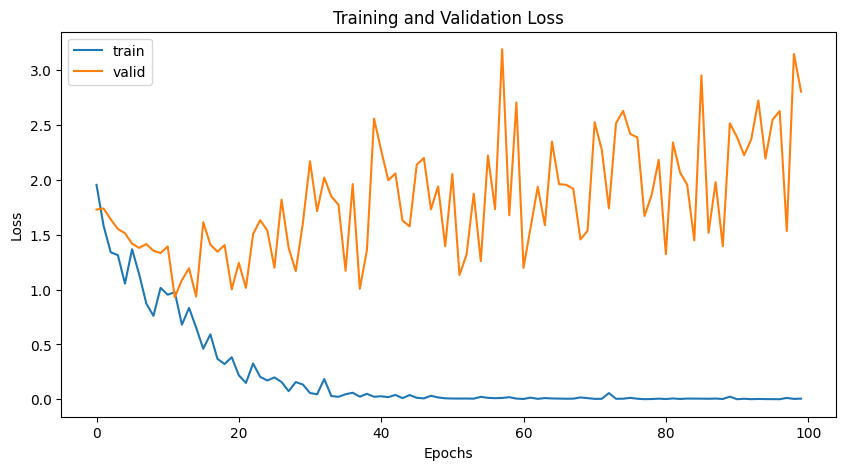

In [13]:
import matplotlib.pyplot as plt

# Load losses from files
with open("train_loss.txt", "r") as file:
    train_losses = [float(line.strip()) for line in file]

with open("test_loss.txt", "r") as file:
    valid_losses = [float(line.strip()) for line in file]

# Plot losses
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
plt.plot(valid_losses,label="valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

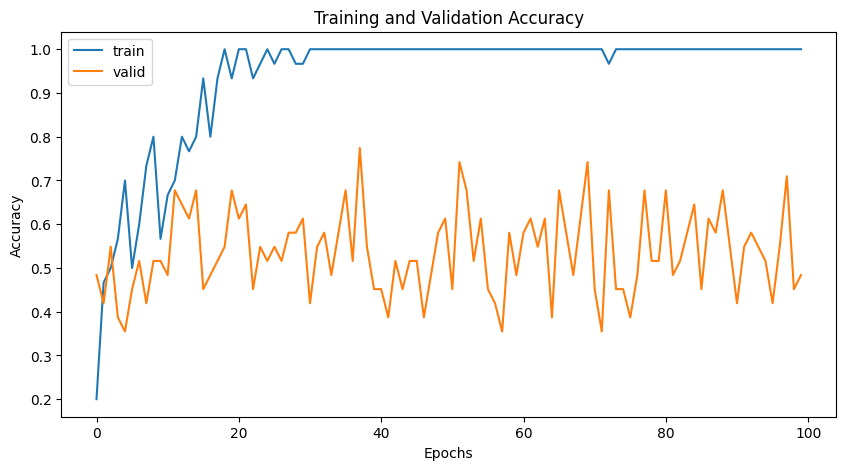

In [14]:
import matplotlib.pyplot as plt

# Load accuracies from files
with open("train_accuracy.txt", "r") as file:
    train_accuracies = [float(line.strip()) for line in file]

with open("test_accuracy.txt", "r") as file:
    valid_accuracies = [float(line.strip()) for line in file]

# Plot accuracies
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies,label="train")
plt.plot(valid_accuracies,label="valid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [15]:
from google.colab import files
files.download("train_loss.txt")
files.download("test_loss.txt")
files.download("train_accuracy.txt")
files.download("test_accuracy.txt")
files.download("DenseNet_metrics.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>